# The Nose Knows
### A Dog Breed Classifier


## Overview
In this project, I have used Keras and Tensorflow to develop, train, and test a convolutional neural network tailored for dog breed prediction. The application of AI in predicting dog breeds holds promise for mitigating the expenses associated with genetic testing. Leveraging machine learning techniques may uncover subtle features that humans cannot perceive. In this endeavor, I will explain the methodology for my process for classifing images of the diverse dog breed images.

## Business Problem
Rescues and animal shelters face a significant challenge in accurately identifying the breeds of dogs in their care, typically relying on the judgement of staff members and based solely on appearance. Genetic testing can provide more definitive answers, but this presents a costly solution. The reliance on subjective assessment and expensive genetic testing can contribute to inefficiencies and potential financial strain for both rescues and adopters. The opportunity exists to address this issue through the development of a machine learning-based diagnostic tool, capable of identifying dog breeds from images. Such a tool could alleviate the financial burden associated with genetic testing while providing rescues and potential adopters with reliable breed information. This can ultimately facilitate a more informed adoption decision for future dog owners.

## Data
- Dog photo dataset from kaggle
- 120 dog breeds
- 20,000+ photos total: fairly evenly split between training & testing sets
        - 10,222 in training set, labels CSV
        - 10,357 in testing set
        
Fortunately, there was no need for data cleaning as the labels CSV did not contain any null values. To seamlessly associate labels with the corresponding image, I added '.jpg' to the image IDs in the dataframe, ensuring a smooth mapping process.

Importing necessary packages

In [49]:
import pandas as pd
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
import os
import imghdr

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomHeight, RandomWidth, RandomZoom, RandomRotation, RandomFlip
from tensorflow.keras import Model, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import preprocessing
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from PIL import Image
from wordcloud import WordCloud

Importing the CSV with labels and the training & test images

In [2]:
train = "data/dog-breed-identification/train"
test = "data/dog-breed-identification/test"
df=pd.read_csv("data/dog-breed-identification/labels.csv")
df.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

Exploring the dataset

In [3]:
df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Displaying some photos with labels

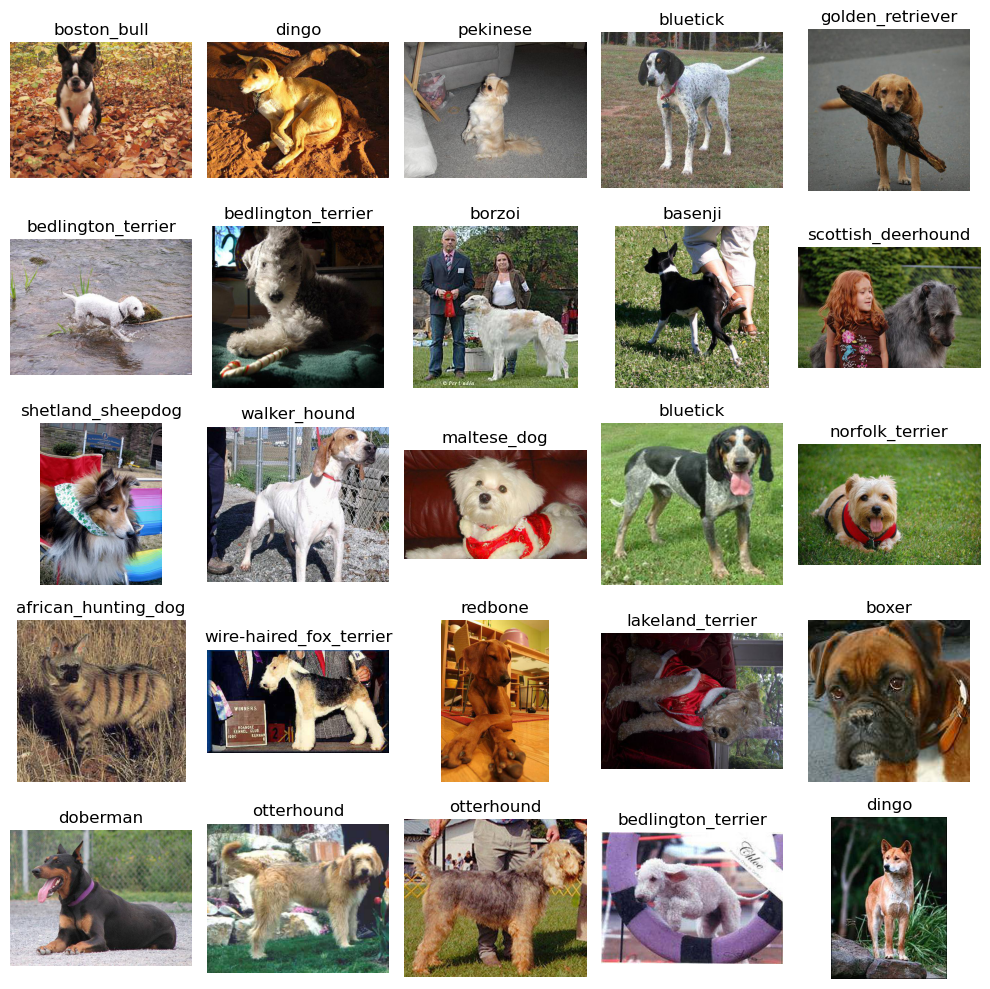

In [4]:
nrow = 5
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(10, 10))

for i, (img_id, breed) in enumerate(df[["id", "breed"]].values[:nrow * ncol]):
    image_path = os.path.join(train, img_id + ".jpg")
    
    # Use PIL to open and convert the image
    image = Image.open(image_path)
    
    # Convert to RGB if the image is not already in RGB mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    row = i // ncol
    col = i % ncol
    
    ax[row, col].imshow(image)
    ax[row, col].set_title(breed)
    ax[row, col].axis("off")

plt.tight_layout()
plt.show()

How many dog breeds are in the dataset? Does it match the description from the webiste?

In [5]:
print("Number of unique dog breeds: ", len(df.breed.unique()))

Number of unique dog breeds:  120


Putting the unique dog breeds into a list

In [6]:
labels = df["breed"].unique().tolist()
print(labels)

['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever', 'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound', 'shetland_sheepdog', 'walker_hound', 'maltese_dog', 'norfolk_terrier', 'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer', 'doberman', 'otterhound', 'standard_schnauzer', 'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn', 'affenpinscher', 'labrador_retriever', 'ibizan_hound', 'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael', 'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier', 'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz', 'german_shepherd', 'greater_swiss_mountain_dog', 'basset', 'australian_terrier', 'schipperke', 'rhodesian_ridgeback', 'irish_setter', 'appenzeller', 'bloodhound', 'samoyed', 'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon', 'border_collie', 'entlebucher', 'collie', 'malamute', 'welsh_springer_spaniel', 'chihuahua', 'saluki', 'pug', 'malino

Creating a bar chart of the amount of photos per breed of dog

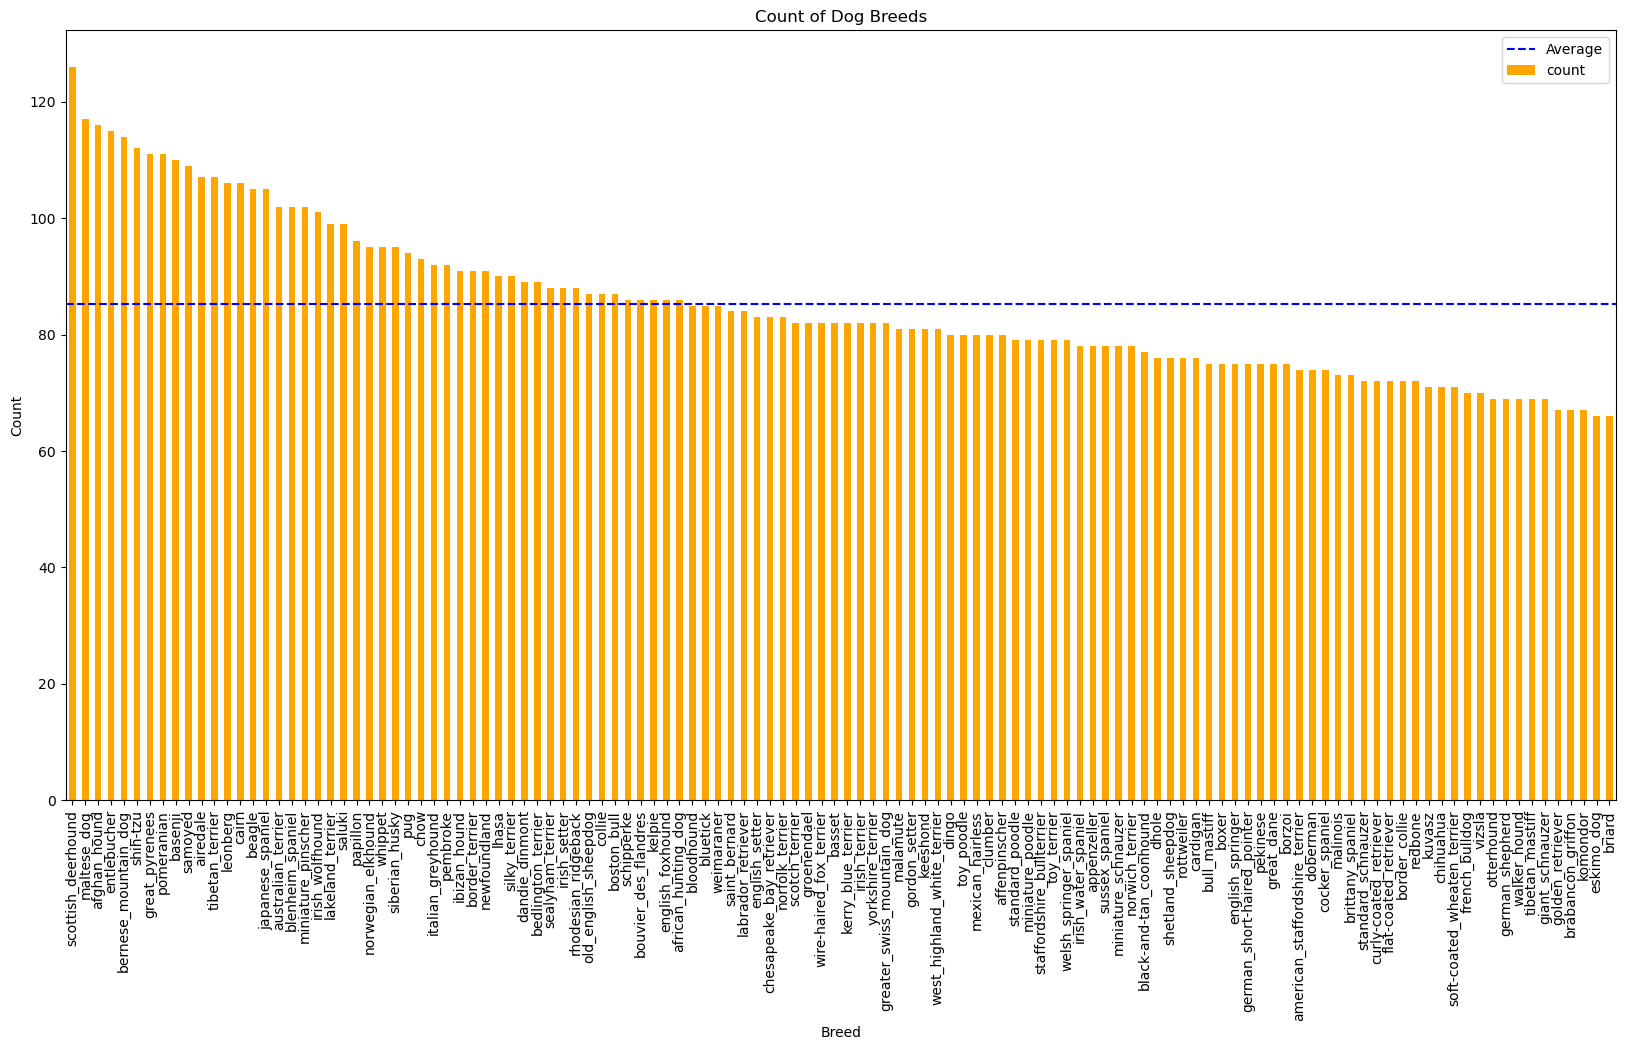

In [7]:
# Plot the bar chart of filname count per breed
ax = df["breed"].value_counts().plot.bar(figsize=(20, 10), color='orange')

# calculate the average value
average_value = df["breed"].value_counts().mean()

# add the average line
ax.axhline(average_value, color='blue', linestyle='--', label='Average')

# Customize the plot as desired
plt.xlabel('Breed')
plt.ylabel('Count')
plt.title('Count of Dog Breeds')
plt.legend();

I made a wordcloud out of the labels for breeds.
Documentation for wordcloud can be found [here](https://www.geeksforgeeks.org/generating-word-cloud-python/).

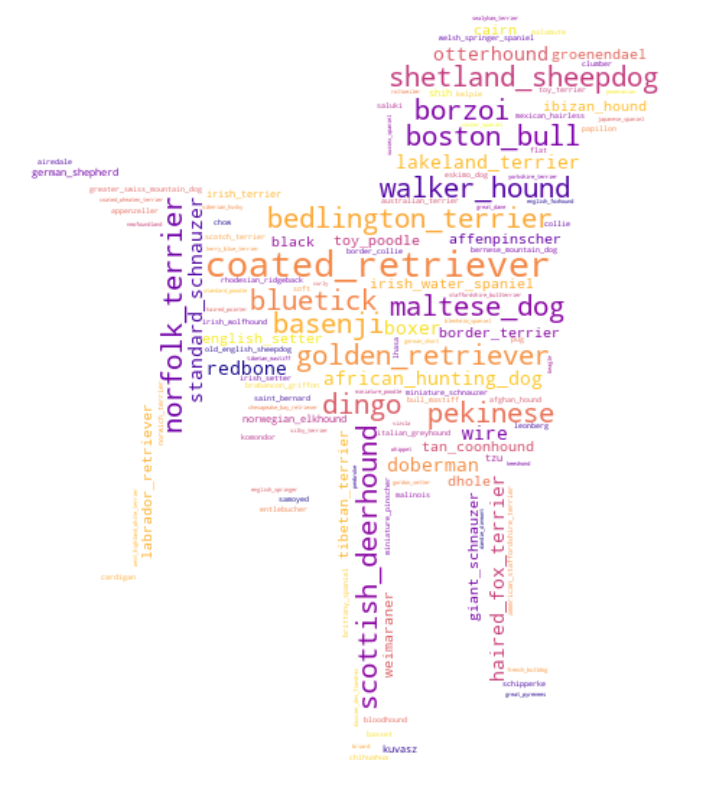

In [75]:
# word cloud of breeds for fun
# join breed names into a single string
text = ' '.join(labels)

mask = np.array(Image.open("data/dog-silhouette.jpg"))

wordcloud = WordCloud(width=600, height=300, 
                      colormap="plasma", 
                      mask=mask, 
                      background_color='white'
                      ).generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Adding a column in the dataframe for 'image_file': the 'id' of the image + '.jpg' made for seamless mapping for future use.

In [9]:
# add '.jpg' to id for image_id
df['image_file'] = df['id'].apply(lambda x: x + ".jpg")
df.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                             image_file  
0  000bec180eb18c7604dcecc8fe0dba07.jpg  
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg  
2  001cdf01b096e06d78e9e5112d419397.jpg  
3  00214f311d5d2247d5dfe4fe24b2303d.jpg  
4  0021f9ceb3235effd7fcde7f7538ed62.jpg

Converted images to numpy array & adjusting the image sizing. Images were also preprocessed.

In [10]:
# converting images to numpy array
image_size = 200  # Adjust to your desired image size

train_data = np.zeros((len(df), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(df["image_file"]):
    img_path = os.path.join(train, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    train_data[i] = img_array
    train_data[i]

Checking the shape of the train_data

In [11]:
train_data.shape

(10222, 100, 100, 3)

Instantiating a label encoder to fit & transform to be used in CNN

In [12]:
num_breed = 120
#image_size = 100
batch_size = 32
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
label_data = encoder.fit_transform(df["breed"].values)

Let's check the shape of the label data

In [13]:
label_data.shape

(10222,)

Train, Test, Split time. I used 20% of the training data for validation.

In [14]:
X = train_data
y = label_data

# # split into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(8177, 8177, 2045, 2045)

## Initial Model
I started with creating a sequential model with convolutional, dense, & output layers to see what the initial outcome would be. It wasn't bad, but it wasn't great. It was initially very overfit.

[Here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) is where you can find documenation on a Sequential model.

In [15]:
# Create a Sequential model
base_model = Sequential()

# Add Convolutional layers
base_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(64, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

base_model.add(Conv2D(128, (3, 3), activation='relu'))
base_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
base_model.add(Flatten())
base_model.add(Dense(128, activation='relu'))
base_model.add(Dense(120, activation='softmax'))  # Assuming 10 output classes

# Compile the model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

First run of the model with the data

In [17]:
first = base_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)

Epoch 1/20


128/128 [==============================] - 27s 203ms/step - loss: 4.7193 - accuracy: 0.0172 - val_loss: 4.5889 - val_accuracy: 0.0269
Epoch 2/20
128/128 [==============================] - 29s 226ms/step - loss: 4.4420 - accuracy: 0.0401 - val_loss: 4.4087 - val_accuracy: 0.0342
Epoch 3/20
128/128 [==============================] - 31s 243ms/step - loss: 4.2365 - accuracy: 0.0629 - val_loss: 4.3976 - val_accuracy: 0.0518
Epoch 4/20
128/128 [==============================] - 30s 238ms/step - loss: 4.0014 - accuracy: 0.0987 - val_loss: 4.3485 - val_accuracy: 0.0548
Epoch 5/20
128/128 [==============================] - 31s 240ms/step - loss: 3.6752 - accuracy: 0.1546 - val_loss: 4.5042 - val_accuracy: 0.0636
Epoch 6/20
128/128 [==============================] - 30s 232ms/step - loss: 3.2456 - accuracy: 0.2295 - val_loss: 4.7580 - val_accuracy: 0.0650
Epoch 7/20
128/128 [==============================] - 30s 233ms/step - loss: 2.7154 - accuracy: 0.3366 - val_loss: 5.0111 - val_

This model is severely overfit. The training accuracy is at 97% and the validation accuracy is at 5%.

Here is a graph of the training & validation accuracy.

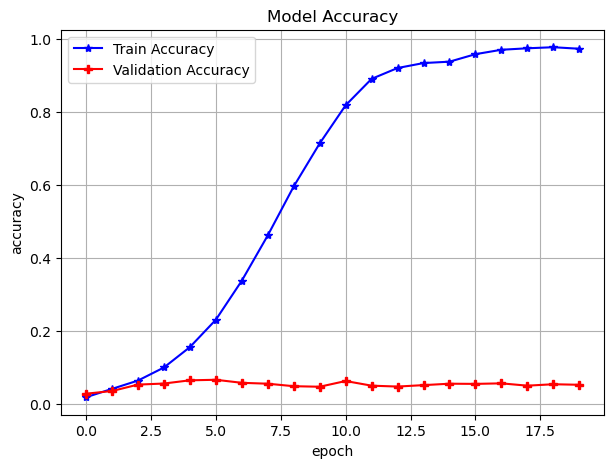

In [18]:
# graph of accuracy of training & validation data
plt.figure(figsize=(7,5))
plt.plot(first.history['accuracy'],label="Train Accuracy",color="blue",marker="*")
plt.plot(first.history['val_accuracy'],label="Validation Accuracy",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

And here is a graph looking at the training & validation loss.

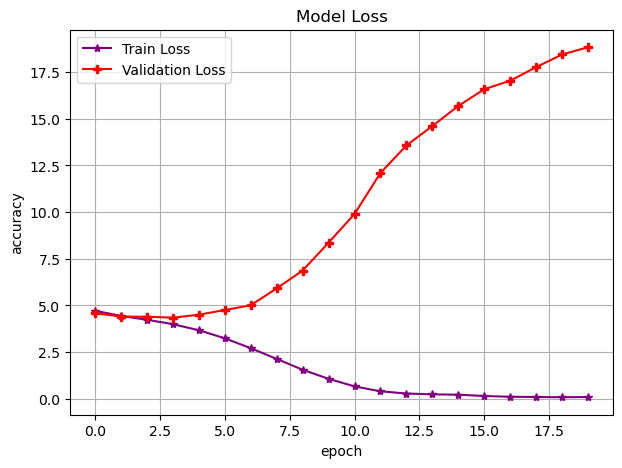

In [19]:
# graph of the loss of training & validation data
plt.figure(figsize=(7,5))
plt.plot(first.history['loss'],label="Train Loss",color="purple",marker="*")
plt.plot(first.history['val_loss'],label="Validation Loss",color="red",marker="P")
plt.grid(True)
plt.legend()
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

#### Summary of the Inital Model
- Training loss: 0.0988
- Training Accuracy: 97%
- Validation loss: 18.23
- Validation Accuracy: 5.04%

Preprocess the testing images the same way as the training/validation set

In [20]:
# Preprocessing test images like the training set
# List all image files in the testing data path
test_image_files = os.listdir(test)

# Specify the image size
image_size = 200  # Adjust to your desired image size

# Preprocess testing data
test_data = np.zeros((len(test_image_files), image_size, image_size, 3), dtype="float32")

for i, img_id in enumerate(test_image_files):
    img_path = os.path.join(test, img_id)
    img = Image.open(img_path)
    
    # Resize the image
    img = img.resize((image_size, image_size))
    
    # Convert to array and preprocess
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    
    test_data[i] = img_array

Make predictions using the testing images

In [21]:
# Make predictions on the testing data
predictions = base_model.predict(test_data)

324/324 [==============================] - 9s 27ms/step


Evaluating the model on the testing data: loss score
- ended up being useless

- Test loss: "0"

The 0 is in quotes because the loss wasn't actually calculated accurately. There were no labels for the testing images, so there is currently no way to evaluate the model's performance.

In [22]:
# Evaluate the model on the testing data
evaluation_results = base_model.evaluate(test_data)

# Extract the loss score
loss_score = evaluation_results[0]

# Print the loss score
print(f'Test Loss: {loss_score:.4f}')

324/324 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Loss: 0.0000


Test loss: 0

Unfortunately, accuracy evaluation was unfeasible due to the absence of labels for the testing data. In an attempt to enhance the model's performance, I experimented with training the base model using more epochs and smaller batch sizes, albeit with negligible impact. Additionally, I conducted a practical test by inputting an image of my own dog into the model. Despite my dog being a Labrador, the model incorrectly predicted him as a Bernese Mountain Dog with a probability of 100%. May we all be so confident...

Some examples of predictions with the probability of the breed

In [27]:
# Load the 'labels' dataframe
df_labels = pd.read_csv("data/dog-breed-identification/labels.csv")

In [28]:
# Function to preprocess the image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

predicted_results = []
for image_filename in os.listdir(test):
    image_path = os.path.join(test, image_filename)
    img_array = preprocess_image(image_path, 100)  # Assuming image size is 100x100
    predictions = base_model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    #predicted_breed = label_encoder.inverse_transform([predicted_class_index])[0]
    predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
    predicted_probability = predictions[0][predicted_class_index]
    predicted_results.append((image_filename, predicted_breed, predicted_probability))

# Create a dataframe from the predicted results
pred_prob_df = pd.DataFrame(predicted_results, columns=["Image Filename", "Predicted Breed", "Predicted Probability"])

pred_prob_df

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 23ms/step


Image Filename Predicted Breed  \
0      000621fb3cbb32d8935728e48679680e.jpg        malinois   
1      00102ee9d8eb90812350685311fe5890.jpg  english_setter   
2      0012a730dfa437f5f3613fb75efcd4ce.jpg  english_setter   
3      001510bc8570bbeee98c8d80c8a95ec1.jpg  english_setter   
4      001a5f3114548acdefa3d4da05474c2e.jpg  english_setter   
...                                     ...             ...   
10352  ffeda8623d4eee33c6d1156a2ecbfcf8.jpg  english_setter   
10353  fff1ec9e6e413275984966f745a313b0.jpg        malinois   
10354  fff74b59b758bbbf13a5793182a9bbe4.jpg        malinois   
10355  fff7d50d848e8014ac1e9172dc6762a3.jpg  english_setter   
10356  fffbff22c1f51e3dc80c4bf04089545b.jpg  english_setter   

       Predicted Probability  
0                   0.526983  
1                   0.986909  
2                   0.929040  
3                   0.948019  
4                   0.635095  
...                      ...  
10352               0.756844  
10353               0.680794  
10354               0.978032  
10355               0.964049  
10356               0.999864  

[10357 rows x 3 columns]

In [30]:
# Predict on test images and map predicted class indices to breed names
predicted_breeds = []
for image_filename in os.listdir(test):
    image_path = os.path.join(test, image_filename)
    img_array = preprocess_image(image_path, 100)  # Assuming image size is 100x100
    predictions = base_model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
    predicted_breeds.append(predicted_breed)

# Print the predicted breed for each image
for image_filename, predicted_breed in zip(os.listdir(test), predicted_breeds):
    print(f"Image: {image_filename}, Predicted Breed: {predicted_breed}")

1/1 [==============================] - 0s 33ms/step
Image: 000621fb3cbb32d8935728e48679680e.jpg, Predicted Breed: malinois
Image: 00102ee9d8eb90812350685311fe5890.jpg, Predicted Breed: english_setter
Image: 0012a730dfa437f5f3613fb75efcd4ce.jpg, Predicted Breed: english_setter
Image: 001510bc8570bbeee98c8d80c8a95ec1.jpg, Predicted Breed: english_setter
Image: 001a5f3114548acdefa3d4da05474c2e.jpg, Predicted Breed: english_setter
Image: 00225dcd3e4d2410dd53239f95c0352f.jpg, Predicted Breed: english_setter
Image: 002c2a3117c2193b4d26400ce431eebd.jpg, Predicted Breed: malinois
Image: 002c58d413a521ae8d1a5daeb35fc803.jpg, Predicted Breed: english_setter
Image: 002f80396f1e3db687c5932d7978b196.jpg, Predicted Breed: malinois
Image: 0036c6bcec6031be9e62a257b1c3c442.jpg, Predicted Breed: english_setter
Image: 0041940322116ae58c38130f5a6f71f9.jpg, Predicted Breed: english_setter
Image: 0042d6bf3e5f3700865886db32689436.jpg, Predicted Breed: malinois
Image: 004476c96f575879af4af471af65cae8.jpg, Pre

In [31]:
# Create a dataframe with image filenames and predicted breed names
predictions_df = pd.DataFrame({
    "Image Filename": os.listdir(test),
    "Predicted Breed": predicted_breeds
})

predictions_df

Image Filename Predicted Breed
0      000621fb3cbb32d8935728e48679680e.jpg        malinois
1      00102ee9d8eb90812350685311fe5890.jpg  english_setter
2      0012a730dfa437f5f3613fb75efcd4ce.jpg  english_setter
3      001510bc8570bbeee98c8d80c8a95ec1.jpg  english_setter
4      001a5f3114548acdefa3d4da05474c2e.jpg  english_setter
...                                     ...             ...
10352  ffeda8623d4eee33c6d1156a2ecbfcf8.jpg  english_setter
10353  fff1ec9e6e413275984966f745a313b0.jpg        malinois
10354  fff74b59b758bbbf13a5793182a9bbe4.jpg        malinois
10355  fff7d50d848e8014ac1e9172dc6762a3.jpg  english_setter
10356  fffbff22c1f51e3dc80c4bf04089545b.jpg  english_setter

[10357 rows x 2 columns]

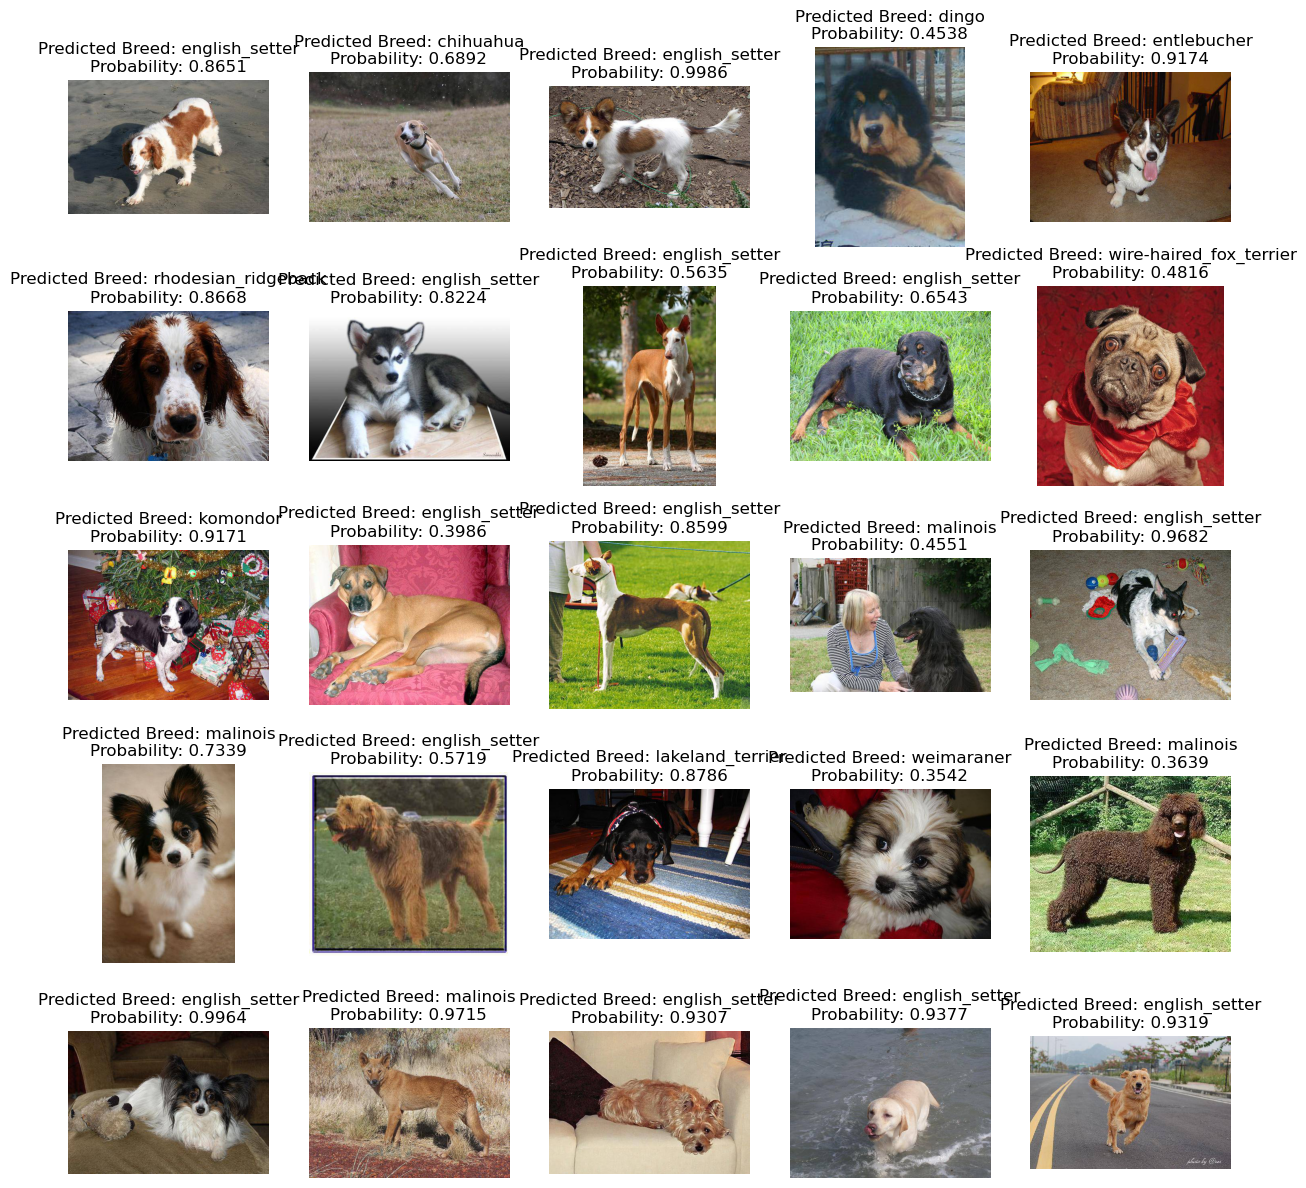

In [32]:
num_images_to_display = 25
random_indices = random.sample(range(len(predictions_df)), num_images_to_display)

# Plot the images with their predicted breed names and probabilities
plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    image_filename = pred_prob_df.loc[idx, "Image Filename"]
    predicted_breed = pred_prob_df.loc[idx, "Predicted Breed"]
    predicted_probability = pred_prob_df.loc[idx, "Predicted Probability"]
    
    # Load and display the image
    image_path = os.path.join(test, image_filename)
    img = Image.open(image_path)
    
    row = i // 5
    col = i % 5
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.4f}")
    plt.axis("off")

plt.show()

I had the base model predict what breed my dog is. Hint, he's not a rhodesian ridgeback.

1/1 [==============================] - 0s 63ms/step


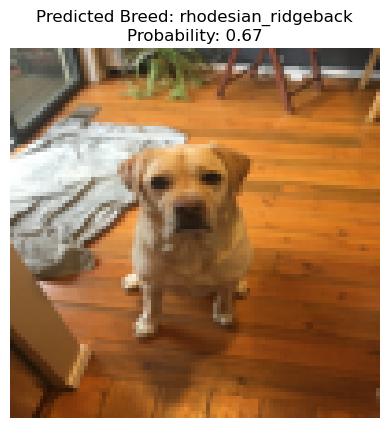

In [36]:
# Function to preprocess the image
def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize((image_size, image_size))
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Path to the locally saved image
image_path = r"data/IMG_6753.jpg"

# Preprocess the image
img, preprocessed_img = preprocess_image(image_path, 200)  # Assuming image size is 100x100

# Rotate the image
img = img.rotate(270, expand=True)

# Use the pre-trained base_model to predict
predictions = base_model.predict(preprocessed_img)
predicted_class_index = np.argmax(predictions)
predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class

# Display the image
plt.imshow(img)
plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()

### Model Tuning

During the refinement process, several enhacements were made the the model architecture, including the addition of an extra layer, incorporation of dropout and L2 regularization, as well as an increase in the number of nodes.

The [Model Tuning notebook](https://github.com/K-Pegg/Nose_Knows/blob/main/notebooks/Model_Tuning.ipynb) shows in depth the steps that I took to attempt creating a more accurate model & dealing with the overfittedness.

Although accurate assessment was impeded by the absence of labels for the testing data, efforts to mitigate overfitting were successful, resulting in a modest improvement in validation accuracy. Notably, the model achieved a training loss of 2.74 with an accuracy of 30%, while the validation loss stood at 4.86 with a validation accuracy of 9.03%.

### Data Augmentation

Furthermore, data augmentation techniques were implemented to assist in training of the model: random flipping, rotation, contrast, and zoom. This allows the model to see more data & in different ways.

Here is the documentation I used for [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [50]:
# adding a data augmentation layer
data_aug = Sequential([                                    
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomContrast(0.2)                                  
], name='data_augmentation')

split_model = Sequential(
    data_aug
)

# Add Convolutional layers with dropout
split_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
split_model.add(MaxPooling2D((2, 2)))
split_model.add(Dropout(0.25))  # Add dropout after the first convolutional layer

split_model.add(Conv2D(64, (3, 3), activation='relu'))
split_model.add(MaxPooling2D((2, 2)))

split_model.add(Conv2D(128, (3, 3), activation='relu'))
split_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
split_model.add(Flatten())
split_model.add(Dense(256, activation='relu'))  # Increase the number of nodes in this dense layer
split_model.add(Dense(128, activation='relu'))
split_model.add(Dense(120, activation='softmax'))  # 120 output classes

# Compile the model
split_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use validation_split parameter in the fit function to split the training data into training and validation sets

split_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)

Epoch 1/50
128/128 [==============================] - 39s 293ms/step - loss: 4.7897 - accuracy: 0.0139 - val_loss: 4.7350 - val_accuracy: 0.0117
Epoch 2/50
128/128 [==============================] - 39s 306ms/step - loss: 4.6095 - accuracy: 0.0236 - val_loss: 4.9490 - val_accuracy: 0.0205
Epoch 3/50
128/128 [==============================] - 39s 308ms/step - loss: 4.4651 - accuracy: 0.0347 - val_loss: 5.4231 - val_accuracy: 0.0137
Epoch 4/50
128/128 [==============================] - 39s 306ms/step - loss: 4.3902 - accuracy: 0.0440 - val_loss: 5.4910 - val_accuracy: 0.0166
Epoch 5/50
128/128 [==============================] - 39s 307ms/step - loss: 4.3411 - accuracy: 0.0489 - val_loss: 6.4805 - val_accuracy: 0.0108
Epoch 6/50
128/128 [==============================] - 39s 305ms/step - loss: 4.2888 - accuracy: 0.0571 - val_loss: 5.6965 - val_accuracy: 0.0166
Epoch 7/50
128/128 [==============================] - 40s 309ms/step - loss: 4.2370 - accuracy: 0.0594 - val_loss: 5.4590 - val_ac

### Train, Test Splits

Various train-test splits were explored with and without testing data in the training process.

In [51]:
X = train_data
y = label_data

X_train_temp, X_test2, y_train_temp, _ = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42)


This iteration used two train_test_split in order to use the actual testing data in the model. This helped with the overfittedness, but decreased the accuracy of the training data down to 30%, while the validation accuracy was 9.03%. A teeny bit better, but still not great. You can see the models in detail in the [train_test_splits]() notebook.

After realizing I didn't have loads of time left, I ended up using the training images & labels to create a testing set in order to evaluate the model. I used 20% of the data for testing.

In [52]:
X2 = train_data
y2 = label_data

# split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X2,
                                                  y2, 
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(8177, 8177, 2045, 2045)

### Final Model

Here is what my final model consisted of.

In [53]:
# adding a data augmentation layer
data_aug = Sequential([                                    
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomContrast(0.2)                                  
], name='data_augmentation')

final_model = Sequential(
    data_aug
)

# Add Convolutional layers with dropout
final_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
final_model.add(MaxPooling2D((2, 2)))
final_model.add(Dropout(0.25))  # Add dropout after the first convolutional layer

final_model.add(Conv2D(64, (3, 3), activation='relu'))
final_model.add(MaxPooling2D((2, 2)))

final_model.add(Conv2D(128, (3, 3), activation='relu'))
final_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
final_model.add(Flatten())
final_model.add(Dense(256, activation='relu'))  # Increase the number of nodes in this dense layer
final_model.add(Dense(128, activation='relu'))
final_model.add(Dense(120, activation='softmax'))  # 120 output classes

# Compile the model
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use validation_split parameter in the fit function to split the training data into training and validation sets

final_model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
128/128 [==============================] - 37s 275ms/step - loss: 4.7881 - accuracy: 0.0120
Epoch 2/50
128/128 [==============================] - 35s 272ms/step - loss: 4.6134 - accuracy: 0.0241
Epoch 3/50
128/128 [==============================] - 35s 273ms/step - loss: 4.4900 - accuracy: 0.0340
Epoch 4/50
128/128 [==============================] - 35s 275ms/step - loss: 4.4077 - accuracy: 0.0396
Epoch 5/50
128/128 [==============================] - 35s 271ms/step - loss: 4.3343 - accuracy: 0.0468
Epoch 6/50
128/128 [==============================] - 35s 271ms/step - loss: 4.2895 - accuracy: 0.0542
Epoch 7/50
128/128 [==============================] - 39s 308ms/step - loss: 4.2359 - accuracy: 0.0615
Epoch 8/50
128/128 [==============================] - 36s 282ms/step - loss: 4.1893 - accuracy: 0.0665
Epoch 9/50
128/128 [==============================] - 36s 282ms/step - loss: 4.1482 - accuracy: 0.0693
Epoch 10/50
128/128 [==============================] - 36s 282ms/step - l

I, once again, tried to have my final model predict the breed of my dog. He is also not an Irish Setter.

1/1 [==============================] - 0s 90ms/step


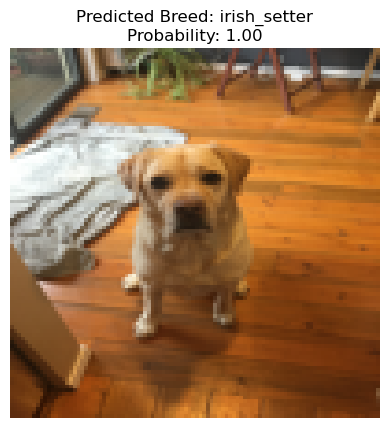

In [54]:
# Path of the image to be predicted
image_path = r"data/IMG_6753.jpg"

# Preprocess the image
preprocessed_img = preprocess_image(image_path, 200)  # Assuming image size is 100x100

# Rotate the image
img_rotated = Image.open(image_path).rotate(270, expand=True)
img_rotated = img_rotated.resize((200, 200))  # Resize after rotation

# Preprocess the rotated image
preprocessed_rotated_img = np.array(img_rotated) #/ 255.0  # Normalize pixel values
preprocessed_rotated_img = np.expand_dims(preprocessed_rotated_img, axis=0)  # Add batch dimension

# Use the pre-trained model to predict the breed
predictions = final_model.predict(preprocessed_rotated_img)
predicted_class_index = np.argmax(predictions)
predicted_breed = df_labels.iloc[predicted_class_index]["breed"]
predicted_probability = predictions[0][predicted_class_index]  # Probability of the predicted class

# Display the image
plt.imshow(img_rotated)
plt.title(f"Predicted Breed: {predicted_breed}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()

### Evaluation
Due to the absence of labels for the testing data, a comprehensive evaluation of the model's accuracy was unattainable. Furthermore, the sample of images used for testing purposes exhibited inaccuracies, showing to erratic probability distributions. In an effort to gain insights into model performance, a comparison with a pre-trained model will be introduced below.

##### Creating a Testing Data Set

Since this particular dataset did not come with labels for the testing images (it was part of a kaggle competition & they did not have labels for the testing images to prevent cheating), I decided to create my own. This would have taken a lot of time. I was going to add 200-250 images, out of the 10,000+ from the testing images & looking at the images one by one to determine breed with the help of Google Lens. At first I considered selecting 200-250 "random" images of my own choosing, so how random would those actually be?

Instead I chose to have write some code for Python to do that for me, since that'll likely be a bit more random.

Thanks to [stack exchange](https://stackoverflow.com/questions/59068321/placing-randomly-selected-images-into-new-folder) for some help with that code.

In [55]:
# Path to the source folder containing images
source_folder = 'data/dog-breed-identification/test'

# Path to the destination folder where random images will be copied
destination_folder = 'data/dog-breed-identification/test2'

# Number of random images to select
num_random_images = 250

# List all files in the source folder
files = os.listdir(source_folder)

# Randomly select 'num_random_images' files
random_files = random.sample(files, num_random_images)

# Create an empty DataFrame to store filenames and paths
ri_data = {'Filename': [], 'Path': []}

# Copy selected files to the destination folder and add them to the DataFrame
for file in random_files:
    source_file_path = os.path.join(source_folder, file)
    destination_file_path = os.path.join(destination_folder, file)
    
    # Copy file to destination folder
    shutil.copyfile(source_file_path, destination_file_path)
    
    # Append filename and path to the DataFrame
    ri_data['Filename'].append(file)
    ri_data['Path'].append(destination_file_path)

# Create a DataFrame from the data
rand_images_df = pd.DataFrame(ri_data)

# Save the DataFrame to a CSV file
rand_images_df.to_csv('data/dog-breed-identification/random_images.csv', index=False)

# Display the DataFrame
#rand_images_df

That was neat to learn & will be useful in the future, but I ended up creating testing data (20%) from the training data so that I didn't have to search through 250 photos & try to line up labels on my own.

Here are the predictions for X_test using the final model.

In [58]:
# Get predictions
y_pred = final_model.predict(X_test)

64/64 [==============================] - 2s 27ms/step


The testing accuracy was 2.35%, which is ever so slightly better than the model just randomly guessing.

In [59]:
# Evaluate the model on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

64/64 [==============================] - 2s 28ms/step - loss: 12.3206 - accuracy: 0.0235
Test Loss: 12.32058048248291
Test Accuracy: 0.023471882566809654


### Breed Categories
Subsequent iterations saw the introduction of a new categorical column for dog breeds: herding, working, sporting, non-sporting, hound, terrier, toy, and wild. I aimed to reduce the number of classes in hopes that it would help the model have better performance. This refinement led to a notable increase in accuracy for both the training and validation data. Specifically, the model achieved a reduced training loss of 1.495 with an accuracy of 43.78%, while the validation loss decreased to 1.997 with a validation accuracy of 28.08%.

In [78]:
# Create a dictionary mapping each breed to its category
breed_to_category = {
'boston_bull': 'non-sporting',
 'dingo': 'wild',
 'pekinese': 'toy',
 'bluetick': 'hound',
 'golden_retriever': 'sporting',
 'bedlington_terrier': 'terrier',
 'borzoi': 'hound',
 'basenji': 'hound',
 'scottish_deerhound': 'hound',
 'shetland_sheepdog': 'herding',
 'walker_hound': 'hound',
 'maltese_dog': 'toy',
 'norfolk_terrier': 'terrier',
 'african_hunting_dog': 'wild',
 'wire-haired_fox_terrier': 'terrier',
 'redbone': 'hound',
 'lakeland_terrier': 'terrier',
 'boxer': 'working',
 'doberman': 'working',
 'otterhound': 'hound',
 'standard_schnauzer': 'working',
 'irish_water_spaniel': 'sporting',
 'black-and-tan_coonhound': 'hound',
 'cairn': 'terrier',
 'affenpinscher': 'toy',
 'labrador_retriever': 'sporting',
 'ibizan_hound': 'hound',
 'english_setter': 'sporting',
 'weimaraner': 'sporting',
 'giant_schnauzer': 'working',
 'groenendael': 'herding',
 'dhole': 'wild',
 'toy_poodle': 'toy',
 'border_terrier': 'terrier',
 'tibetan_terrier': 'non-sporting',
 'norwegian_elkhound': 'hound',
 'shih-tzu': 'toy',
 'irish_terrier': 'terrier',
 'kuvasz': 'working',
 'german_shepherd': 'herding',
 'greater_swiss_mountain_dog': 'working',
 'basset': 'hound',
 'australian_terrier': 'terrier',
 'schipperke': 'non-sporting',
 'rhodesian_ridgeback': 'hound',
 'irish_setter': 'sporting',
 'appenzeller': 'working',
 'bloodhound': 'hound',
 'samoyed': 'working',
 'miniature_schnauzer': 'terrier',
 'brittany_spaniel': 'sporting',
 'kelpie': 'herding',
 'papillon': 'toy',
 'border_collie': 'herding',
 'entlebucher': 'herding',
 'collie': 'herding',
 'malamute': 'working',
 'welsh_springer_spaniel': 'sporting',
 'chihuahua': 'toy',
 'saluki': 'hound',
 'pug': 'toy',
 'malinois': 'herding',
 'komondor': 'working',
 'airedale': 'terrier',
 'leonberg': 'working',
 'mexican_hairless': 'non-sporting',
 'bull_mastiff': 'working',
 'bernese_mountain_dog': 'working',
 'american_staffordshire_terrier': 'terrier',
 'lhasa': 'non-sporting',
 'cardigan': 'herding',
 'italian_greyhound': 'toy',
 'clumber': 'sporting',
 'scotch_terrier': 'terrier',
 'afghan_hound': 'hound',
 'old_english_sheepdog': 'herding',
 'saint_bernard': 'working',
 'miniature_pinscher': 'toy',
 'eskimo_dog': 'non-sporting',
 'irish_wolfhound': 'hound',
 'brabancon_griffon': 'toy',
 'toy_terrier': 'toy',
 'chow': 'non-sporting',
 'flat-coated_retriever': 'sporting',
 'norwich_terrier': 'terrier',
 'soft-coated_wheaten_terrier': 'terrier',
 'staffordshire_bullterrier': 'terrier',
 'english_foxhound': 'hound',
 'gordon_setter': 'sporting',
 'siberian_husky': 'working',
 'newfoundland': 'working',
 'briard': 'herding',
 'chesapeake_bay_retriever': 'sporting',
 'dandie_dinmont': 'terrier',
 'great_pyrenees': 'working',
 'beagle': 'hound',
 'vizsla': 'sporting',
 'west_highland_white_terrier': 'terrier',
 'kerry_blue_terrier': 'terrier',
 'whippet': 'hound',
 'sealyham_terrier': 'terrier',
 'standard_poodle': 'non-sporting',
 'keeshond': 'non-sporting',
 'japanese_spaniel': 'toy',
 'miniature_poodle': 'non-sporting',
 'pomeranian': 'toy',
 'curly-coated_retriever': 'sporting',
 'yorkshire_terrier': 'toy',
 'pembroke': 'herding',
 'great_dane': 'working',
 'blenheim_spaniel': 'toy',
 'silky_terrier': 'toy',
 'sussex_spaniel': 'sporting',
 'german_short-haired_pointer': 'sporting',
 'french_bulldog': 'non-sporting',
 'bouvier_des_flandres': 'herding',
 'tibetan_mastiff': 'working',
 'english_springer': 'sporting',
 'cocker_spaniel': 'sporting',
 'rottweiler': 'working'
    # Add more breeds and categories as needed
}

# Add a new column 'category' to the DataFrame based on the mapping
df['category'] = df['breed'].map(breed_to_category)

# Display the DataFrame to verify the changes
df

id                     breed  \
0      000bec180eb18c7604dcecc8fe0dba07               boston_bull   
1      001513dfcb2ffafc82cccf4d8bbaba97                     dingo   
2      001cdf01b096e06d78e9e5112d419397                  pekinese   
3      00214f311d5d2247d5dfe4fe24b2303d                  bluetick   
4      0021f9ceb3235effd7fcde7f7538ed62          golden_retriever   
...                                 ...                       ...   
10217  ffd25009d635cfd16e793503ac5edef0                    borzoi   
10218  ffd3f636f7f379c51ba3648a9ff8254f            dandie_dinmont   
10219  ffe2ca6c940cddfee68fa3cc6c63213f                  airedale   
10220  ffe5f6d8e2bff356e9482a80a6e29aac        miniature_pinscher   
10221  fff43b07992508bc822f33d8ffd902ae  chesapeake_bay_retriever   

                                 image_file      category  
0      000bec180eb18c7604dcecc8fe0dba07.jpg  non-sporting  
1      001513dfcb2ffafc82cccf4d8bbaba97.jpg          wild  
2      001cdf01b096e06d78e9e5112d419397.jpg           toy  
3      00214f311d5d2247d5dfe4fe24b2303d.jpg         hound  
4      0021f9ceb3235effd7fcde7f7538ed62.jpg      sporting  
...                                     ...           ...  
10217  ffd25009d635cfd16e793503ac5edef0.jpg         hound  
10218  ffd3f636f7f379c51ba3648a9ff8254f.jpg       terrier  
10219  ffe2ca6c940cddfee68fa3cc6c63213f.jpg       terrier  
10220  ffe5f6d8e2bff356e9482a80a6e29aac.jpg           toy  
10221  fff43b07992508bc822f33d8ffd902ae.jpg      sporting  

[10222 rows x 4 columns]

The categorical labels were encoded to be used in the model.

In [79]:
# instantiate LabelEncoder
encoder = LabelEncoder()

# fit & transform encoder on to label_data
cat_data = encoder.fit_transform(df["category"].values)

I used the same architecture & data augmentation as my final model, but renamed it to 'cat_model' for categories.

In [81]:
X3 = train_data
y3 = cat_data

# split into training & testing sets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X3,
                                                  y3, 
                                                  test_size=0.2,
                                                  random_state=42)

# instantiating a model with the data augmentation layer from above
cat_model = Sequential(
    data_aug
)

# Add Convolutional layers with dropout
cat_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3), 
                  kernel_regularizer=regularizers.l2(0.01) # Adding L2 regularizer
                  ))
cat_model.add(MaxPooling2D((2, 2)))
cat_model.add(Dropout(0.25))  # Add dropout after the first convolutional layer

cat_model.add(Conv2D(64, (3, 3), activation='relu'))
cat_model.add(MaxPooling2D((2, 2)))

cat_model.add(Conv2D(128, (3, 3), activation='relu'))
cat_model.add(MaxPooling2D((2, 2)))

# Flatten the output and add Dense layers for classification
cat_model.add(Flatten())
cat_model.add(Dense(256, activation='relu'))  # Increase the number of nodes in this dense layer
cat_model.add(Dense(128, activation='relu'))
cat_model.add(Dense(120, activation='softmax'))  # 120 output classes

# Compile the model
cat_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Use validation_split parameter in the fit function to split the training data into training and validation sets

cat_model.fit(X_train_cat, y_train_cat, epochs=50, batch_size=64)

Epoch 1/50
128/128 [==============================] - 41s 304ms/step - loss: 2.1753 - accuracy: 0.1660
Epoch 2/50
128/128 [==============================] - 45s 350ms/step - loss: 2.0198 - accuracy: 0.1903
Epoch 3/50
128/128 [==============================] - 46s 359ms/step - loss: 1.9978 - accuracy: 0.1975
Epoch 4/50
128/128 [==============================] - 42s 330ms/step - loss: 1.9870 - accuracy: 0.1981
Epoch 5/50
128/128 [==============================] - 44s 344ms/step - loss: 1.9725 - accuracy: 0.2113
Epoch 6/50
128/128 [==============================] - 41s 319ms/step - loss: 1.9621 - accuracy: 0.2207
Epoch 7/50
128/128 [==============================] - 42s 325ms/step - loss: 1.9628 - accuracy: 0.2248
Epoch 8/50
128/128 [==============================] - 59s 463ms/step - loss: 1.9516 - accuracy: 0.2223
Epoch 9/50
128/128 [==============================] - 57s 448ms/step - loss: 1.9397 - accuracy: 0.2295
Epoch 10/50
128/128 [==============================] - 39s 303ms/step - l

Here I used my model to make predictions on the testing data.

In [82]:
# Get predictions
y_pred_cat = cat_model.predict(X_test_cat)

64/64 [==============================] - 3s 39ms/step


The model did better with the accuracy of its predictions when it had less classes to choose from. It still did not perform super well though.

In [83]:
# Evaluate the model on the test set
test_loss_cat, test_accuracy_cat = cat_model.evaluate(X_test_cat, y_test_cat)

print("Test Loss:", test_loss_cat)
print("Test Accuracy:", test_accuracy_cat)

64/64 [==============================] - 3s 37ms/step - loss: 5.3922 - accuracy: 0.1604
Test Loss: 5.392177104949951
Test Accuracy: 0.1603911966085434


Here is a confusion matrix on the categories.

The model struggled with the toy category the most, and it didn't do very well truly predicting categories.

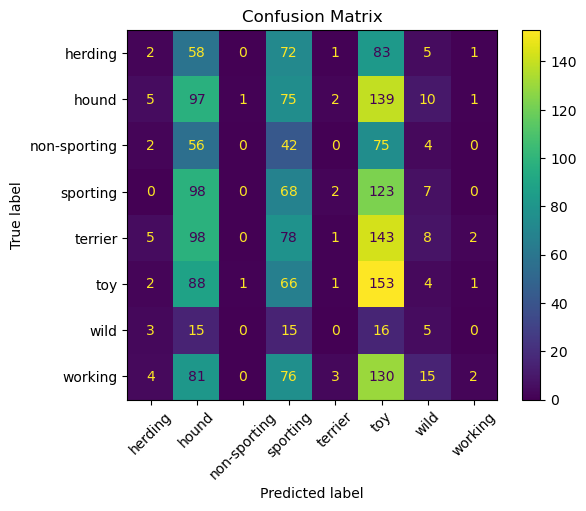

In [88]:
# confusion matrix for cat_model
from sklearn.metrics import ConfusionMatrixDisplay

# Convert predicted probabilities into class labels
y_pred_cat_labels = np.argmax(y_pred_cat, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_cat, y_pred_cat_labels)
# Compute the confusion matrix
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=encoder.classes_)

# Plot the confusion matrix
conf_matrix_display.plot()
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()


Here are some examples of wrong predictions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


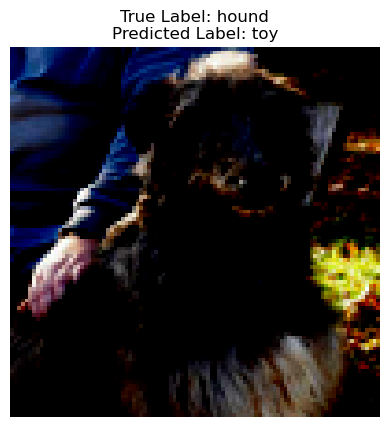

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


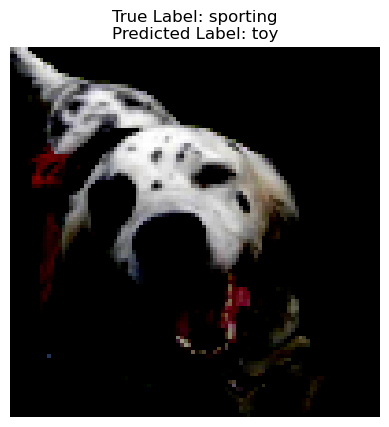

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


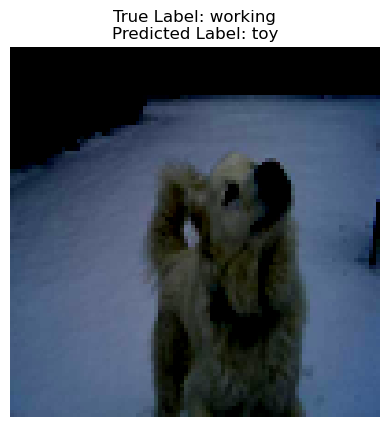

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


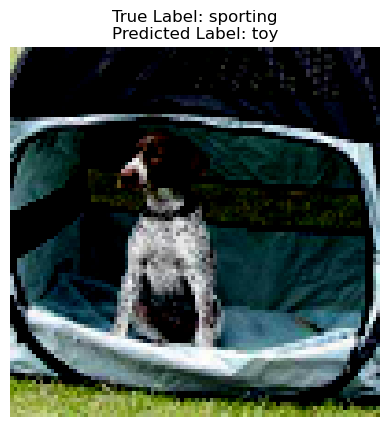

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


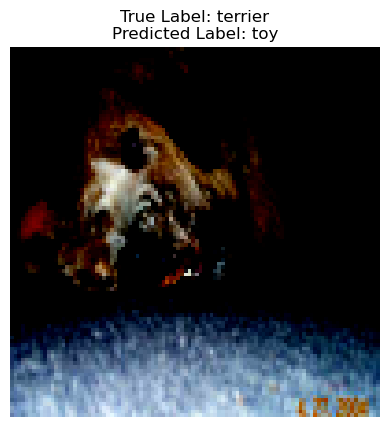

In [85]:
# some examples of wrong predictions
num_wrong_to_display = 5
num_displayed_wrong = 0

# Display images with wrong predictions
for i in range(len(X_test_cat)):
    # Get the true class index, breed, and predicted class index
    true_class_index = y_test_cat[i]
    true_class_label = encoder.inverse_transform([true_class_index])[0]
    predicted_class_index = y_pred_cat_labels[i]
    predicted_class_label = encoder.inverse_transform([predicted_class_index])[0]
    
    # Check if the prediction is wrong
    if true_class_index != predicted_class_index:
        # Display the image
        plt.imshow(X_test_cat[i])
        plt.title(f"True Label: {true_class_label}\nPredicted Label: {predicted_class_label}")
        plt.axis('off')
        plt.show()
        num_displayed_wrong += 1
        
        if num_displayed_wrong == num_wrong_to_display:
            break

And here are some correctly predicted breeds.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


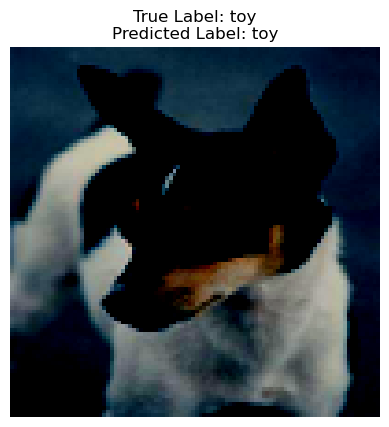

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


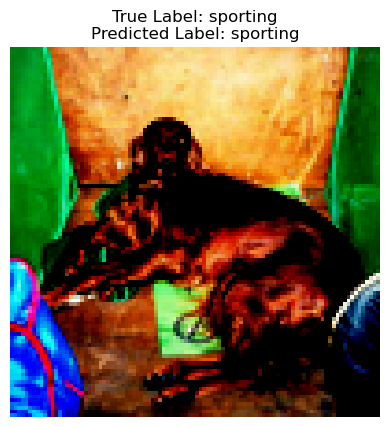

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


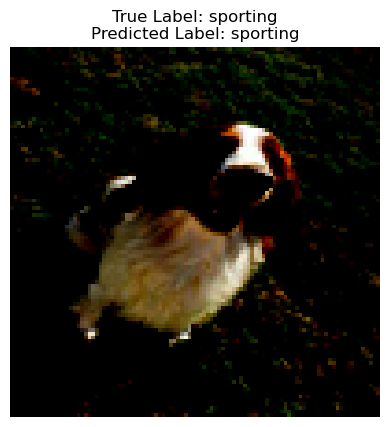

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


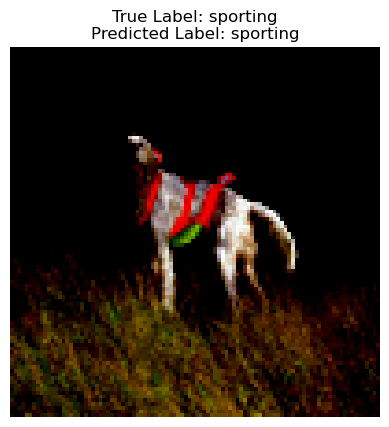

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


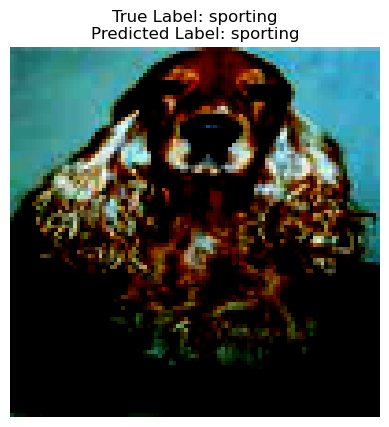

In [86]:
# some examples of correct predictions
num_correct_to_display = 5
num_displayed_correct = 0

# Display images with correct predictions
for i in range(len(X_test_cat)):
    # Get the true class index, breed, and predicted class index
    true_class_index = y_test_cat[i]
    true_class_label = encoder.inverse_transform([true_class_index])[0]
    predicted_class_index = y_pred_cat_labels[i]
    predicted_class_label = encoder.inverse_transform([predicted_class_index])[0]
    
    # Check if the prediction is correct
    if true_class_index == predicted_class_index:
        # Display the image
        plt.imshow(X_test_cat[i])
        plt.title(f"True Label: {true_class_label}\nPredicted Label: {predicted_class_label}")
        plt.axis('off')
        plt.show()
        num_displayed_correct += 1
        
        if num_displayed_correct == num_correct_to_display:
            break

Despite these improvements, a previous notable misclassification occured where my Labrador, who should be categorized as sporting, was identified as in the terrier category with a 100% probability, highlight the ongoing need for refinement and optimization.

![a labrador's predicted category](images/PredCat1.png)

Here's one more test on an image of Dexter, using the final model & the train_test_split that used testing data (& labels) from the training data. I was hoping this photo would give the model a better chance at predicting, but alas... it predicted Dexter in the toy category.

1/1 [==============================] - 0s 26ms/step


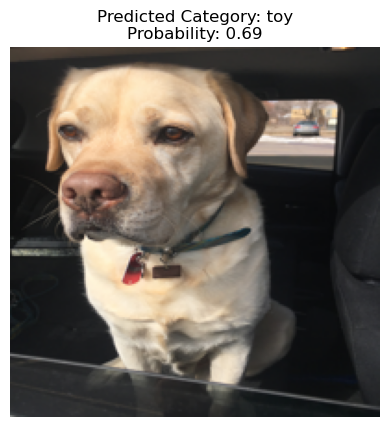

In [96]:
# And one more test for Dexter?
# Load and preprocess the image
image_path_cat = r"images/IMG_DEX.jpg"

# Preprocess the image using the defined function
img_array = preprocess_image(image_path_cat, 100)

# Predict the category using the pre-trained model
predictions = cat_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_category = encoder.classes_[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image and prediction
plt.imshow(img)
plt.title(f"Predicted Category: {predicted_category}\nProbability: {predicted_probability:.2f}")
plt.axis("off")
plt.show()

The model is a little less sure of its choice at least.

### Conclusion
The current model is deemed unsuitable for production deployment due to its inconsistent performance and frequent incorrect predictions. Notably, there exists a substantial disparity in accuracy between the training, validation, and testing sets.

### Next Steps
The following steps are planned to refine the model and enhance its performance:

1. Generating a label CSV for the testing data to enable comprehensive evaluation
2. Implementing further tuning strategies
    - More data/better data
        - Using larger photos in the model (more computational power, more time)
        - Better quality photos
    - Additional layers and/or nodes
    - Extending training duration
    - Leveraging pre-trained models to improve prediction accuracy
3. Incorporating mixed breeds into the model to broaden its scope and improve breed identification accuracy
4. Eventually transitioning to web app production to facilitate user-friendly interface & access